In [22]:
# --- Setup ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.ToTensor()
train_loader = DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=transform),
    batch_size=128, shuffle=True
)
test_loader = DataLoader(
    datasets.MNIST('./data', train=False, download=True, transform=transform),
    batch_size=512, shuffle=False
)


# Autoencoder (AE)

In [24]:
class DenoisingAE(nn.Module):
    def __init__(self):
        super(DenoisingAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z).view(-1, 1, 28, 28)
        return recon

    def get_latents(self, x):
        return self.encoder(x)


In [28]:
def train_ae(model, optimizer, noise=False, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            noisy = x + 0.3 * torch.randn_like(x) if noise else x
            noisy = torch.clamp(noisy, 0., 1.)
            optimizer.zero_grad()
            recon = model(noisy)
            loss = F.mse_loss(recon, x)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


In [30]:
def show_denoised(model):
    model.eval()
    with torch.no_grad():
        x, _ = next(iter(test_loader))
        x = x.to(device)
        noisy = x + 0.3 * torch.randn_like(x)
        noisy = torch.clamp(noisy, 0., 1.)
        recon = model(noisy)

        fig, axs = plt.subplots(3, 10, figsize=(12, 4))
        for i in range(10):
            axs[0, i].imshow(x[i][0].cpu(), cmap='gray')
            axs[1, i].imshow(noisy[i][0].cpu(), cmap='gray')
            axs[2, i].imshow(recon[i][0].cpu(), cmap='gray')
            for j in range(3): axs[j, i].axis('off')
        plt.suptitle("Top: Original | Middle: Noisy | Bottom: Reconstructed")
        plt.show()


In [32]:
def visualize_latents(model, loader, method="tsne"):
    model.eval()
    latents, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            z = model.get_latents(x).cpu().numpy()
            latents.append(z)
            labels.extend(y.numpy())
    latents = np.concatenate(latents)
    if method == "pca":
        reduced = PCA(n_components=2).fit_transform(latents)
    else:
        reduced = TSNE(n_components=2, perplexity=30).fit_transform(latents)

    plt.figure(figsize=(8, 6))
    plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10', s=10, alpha=0.7)
    plt.colorbar()
    plt.title(f"Latent Space ({method.upper()})")
    plt.grid(True)
    plt.show()


Epoch 1, Loss: 0.0508
Epoch 2, Loss: 0.0247
Epoch 3, Loss: 0.0193
Epoch 4, Loss: 0.0165
Epoch 5, Loss: 0.0147


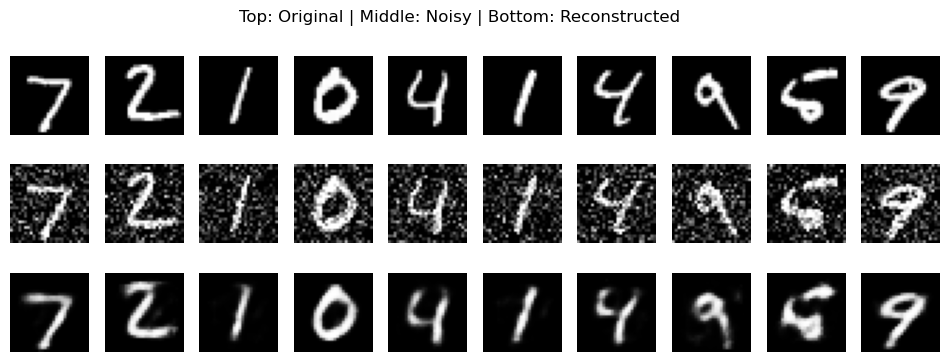

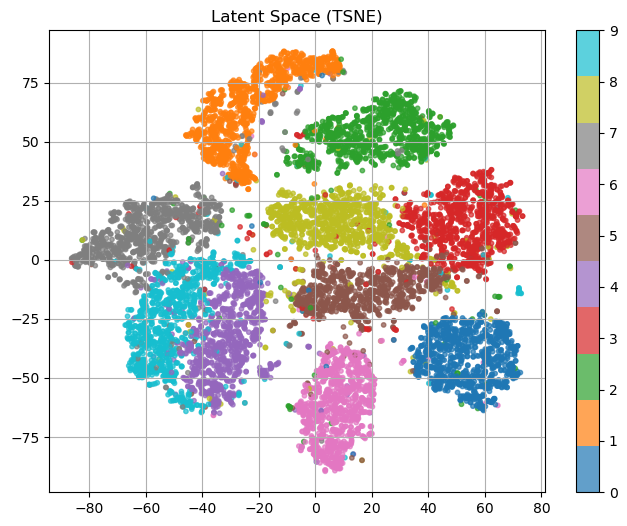

In [34]:
ae = DenoisingAE().to(device)
opt = optim.Adam(ae.parameters(), lr=1e-3)

train_ae(ae, opt, noise=True, epochs=5)
show_denoised(ae)
visualize_latents(ae, test_loader, method="tsne")  # or method="pca"


# Variational Autoencoder (VAE)

In [35]:
class DenoisingVAE(nn.Module):
    def __init__(self):
        super(DenoisingVAE, self).__init__()
        self.fc1 = nn.Linear(28*28, 400)
        self.fc_mu = nn.Linear(400, 20)
        self.fc_logvar = nn.Linear(400, 20)
        self.fc2 = nn.Linear(20, 400)
        self.fc3 = nn.Linear(400, 28*28)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        x = x.view(-1, 28*28)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z).view(-1, 1, 28, 28)
        return recon, mu, logvar

    def get_latents(self, x):
        x = x.view(-1, 28*28)
        mu, _ = self.encode(x)
        return mu


In [36]:
def vae_loss(recon, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div


In [37]:
def train_vae(model, optimizer, noise=False, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            noisy = x + 0.3 * torch.randn_like(x) if noise else x
            noisy = torch.clamp(noisy, 0., 1.)
            optimizer.zero_grad()
            recon, mu, logvar = model(noisy)
            loss = vae_loss(recon, x, mu, logvar)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader.dataset):.4f}")


In [38]:
def show_vae_denoised(model):
    model.eval()
    with torch.no_grad():
        x, _ = next(iter(test_loader))
        x = x.to(device)
        noisy = torch.clamp(x + 0.3 * torch.randn_like(x), 0., 1.)
        recon, _, _ = model(noisy)

        fig, axs = plt.subplots(3, 10, figsize=(12, 4))
        for i in range(10):
            axs[0, i].imshow(x[i][0].cpu(), cmap='gray')
            axs[1, i].imshow(noisy[i][0].cpu(), cmap='gray')
            axs[2, i].imshow(recon[i][0].cpu(), cmap='gray')
            for j in range(3): axs[j, i].axis('off')
        plt.suptitle("Top: Original | Middle: Noisy | Bottom: VAE Output")
        plt.show()


Epoch 1, Loss: 177.0781
Epoch 2, Loss: 132.8456
Epoch 3, Loss: 124.5326
Epoch 4, Loss: 120.4808
Epoch 5, Loss: 118.2634


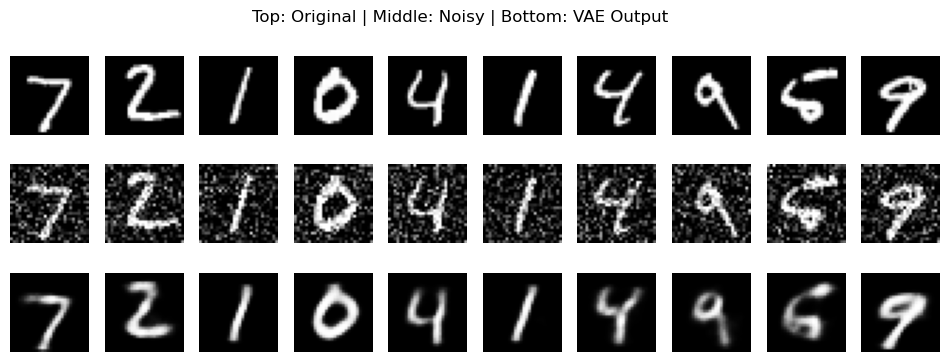

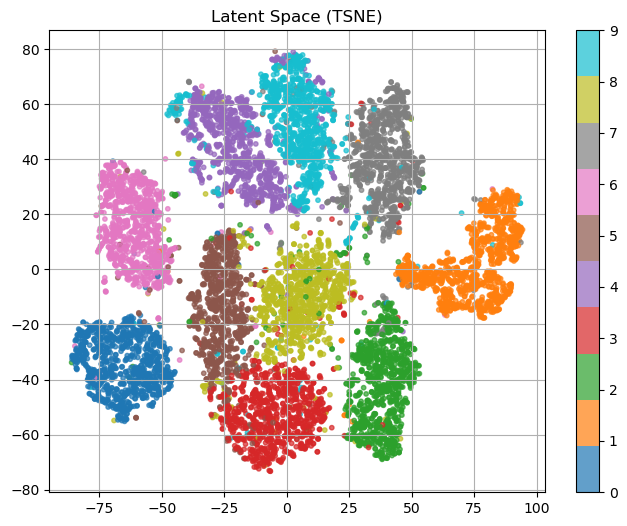

In [44]:
vae = DenoisingVAE().to(device)
vae_opt = optim.Adam(vae.parameters(), lr=1e-3)

train_vae(vae, vae_opt, noise=True, epochs=5)
show_vae_denoised(vae)
visualize_latents(vae, test_loader, method="tsne")


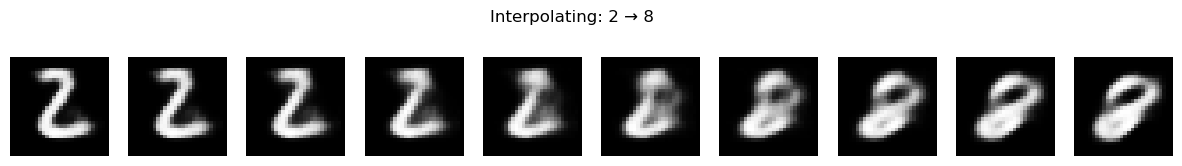

In [106]:
# Latent Interpolation Between Digits (2 to 8)

def interpolate_vae(model, digit1=2, digit2=8, steps=10):
    model.eval()
    x, y = next(iter(test_loader))
    x1 = x[y == digit1][0].unsqueeze(0).to(device)
    x2 = x[y == digit2][0].unsqueeze(0).to(device)

    with torch.no_grad():
        mu1 = model.get_latents(x1)
        mu2 = model.get_latents(x2)
        interpolations = []

        for alpha in torch.linspace(0, 1, steps):
            z = (1 - alpha) * mu1 + alpha * mu2
            out = model.decode(z).view(-1, 1, 28, 28)
            interpolations.append(out)

        fig, axs = plt.subplots(1, steps, figsize=(15, 2))
        for i in range(steps):
            axs[i].imshow(interpolations[i][0][0].cpu(), cmap='gray')
            axs[i].axis('off')
        plt.suptitle(f"Interpolating: {digit1} → {digit2}")
        plt.show()

interpolate_vae(vae, 2, 8)


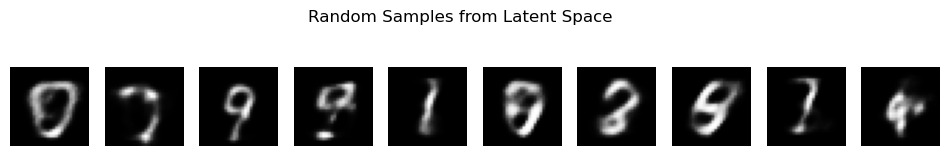

In [98]:
# generate new digit-like images without any input image, by sampling from the standard normal distribution (

def generate_random_images(model, n=10):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n, 20).to(device)
        samples = model.decode(z).view(-1, 1, 28, 28)

        fig, axs = plt.subplots(1, n, figsize=(12, 2))
        for i in range(n):
            axs[i].imshow(samples[i][0].cpu(), cmap='gray')
            axs[i].axis('off')
        plt.suptitle("Random Samples from Latent Space")
        plt.show()

generate_random_images(vae)


In [102]:
# Latent Space Clustering Metrics 

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

def latent_clustering(model, loader, name="Model"):
    model.eval()
    latents, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            z = model.get_latents(x).cpu().numpy()
            latents.append(z)
            labels.extend(y.numpy())
    latents = np.concatenate(latents)
    labels = np.array(labels)

    kmeans = KMeans(n_clusters=10, n_init=10)
    pred_labels = kmeans.fit_predict(latents)

    ari = adjusted_rand_score(labels, pred_labels)
    print(f"[{name}] Adjusted Rand Index (ARI): {ari:.4f}")


latent_clustering(ae, test_loader, name="AE")
latent_clustering(vae, test_loader, name="VAE")

[AE] Adjusted Rand Index (ARI): 0.3605
[VAE] Adjusted Rand Index (ARI): 0.4147


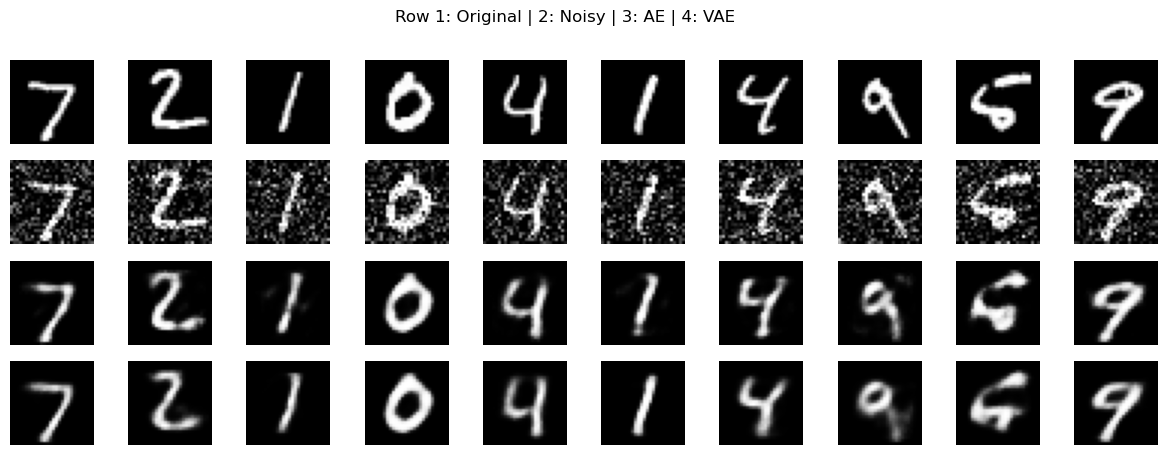

In [104]:
#  Compare AE vs VAE Reconstructions

def compare_reconstructions(ae_model, vae_model):
    ae_model.eval()
    vae_model.eval()
    with torch.no_grad():
        x, _ = next(iter(test_loader))
        x = x.to(device)
        noisy = torch.clamp(x + 0.3 * torch.randn_like(x), 0., 1.)

        ae_recon = ae_model(noisy)
        vae_recon, _, _ = vae_model(noisy)

        fig, axs = plt.subplots(4, 10, figsize=(15, 5))
        for i in range(10):
            axs[0, i].imshow(x[i][0].cpu(), cmap='gray')         # Original
            axs[1, i].imshow(noisy[i][0].cpu(), cmap='gray')     # Noisy
            axs[2, i].imshow(ae_recon[i][0].cpu(), cmap='gray')  # AE output
            axs[3, i].imshow(vae_recon[i][0].cpu(), cmap='gray') # VAE output
            for j in range(4): axs[j, i].axis('off')
        plt.suptitle("Row 1: Original | 2: Noisy | 3: AE | 4: VAE")
        plt.show()

compare_reconstructions(ae, vae)
